<a href="https://colab.research.google.com/github/yicjiang/BA865-2023/blob/main/Image_Based_Music_Piece_Detection_for_Classification_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image-Based Music Piece Detection for Classification Prediction**
### *-- by Yicheng (Victor) Jiang, Boyue Li*

## Table of Contents

1. [Introduction](#intro)
   * 1.1 Summary
   * 1.2 Data Source and Project Structure
2. [Data Extraction and Preprocessing](#preprocess)
   * 2.1 Convert PDF files into Image files
   * 2.2 Data Preprocessing Stage for CNN Model
   * 2.3 Data Preprocessing Stage for RNN Model - Object Character Recognition
3. [Model Training and Selection Stage](#model_train_selection)
   * 3.1 CNN Model 1
   * 3.2 CNN Model with Grid Search
   * 3.3 CNN Model 3 (Selected)
   * 3.4 LSTM Model 
   * 3.5 CNN-LSTM Model Combination (Selected)
4. [Conclusion](#conclusion)
   * 4.1 Business Implementation and Competitor Analysis
   * 4.1 Model Conclusion
   * 4.3 Key Challenges and Limitations
   * 4.4 Relevant Project for Further Study 

## <h1 id="intro">1. Introduction</h1>

### <h3 id="summary">1.1 Summary</h3>

The objective of this project is to build a neural network model capable of categorizing images, particularly musical staffs and notations, into specific categories. The model is intended to aid online music platforms in categorizing musical pieces automatically. Given the constraints of hardware and cloud computing resources, the model's focus is mainly on piano and violin pieces, utilizing approximately **3159 sample images**. During the data exploration and analysis phase, we discovered that music from different categories possessed unique patterns, leading us to perform feature engineering to extract text and symbols from the musical pieces. During the context pre-process part, we **remain the symbols in the dataset, since symbols can mean something in music piece.** After the feature engineering, we built both **Convolutional Neural Network and Long Short-Term Memory Model** to eveulate the models' performance. Finally, **we stack two models together to find the accuracy - combination of CNN and LSTM Model**. In the end of the model selection, both CNN and combination of LSTM and CNN perform slightly high accuracy. CNN model have a stable learning rate reached 47.8% of the validation accuracy, and training model reached 80.1% of model accuracy. Based on current limited resources and cost benefit analysis, both models has pros and cons.

### <h3 id="source">1.2 Data Source and Project Structure</h3>

**Data source**
In the data extraction stage, we attempted to perform the data mining on website that provide music staff and notation, but we unable to get through the reCAPTCHA, so we purchase the music piece online.

**Folders for orginal dataset (in PDF format):**
*   *concerto pieces*:     https://drive.google.com/drive/folders/1yqorcvTQI-STCDhRpn7nzihDO2Wgglja?usp=sharing
*   *prelude pieces*:       https://drive.google.com/drive/folders/1J3jbGpS-RdpkMyox6rNCaWHG4lAT7_Av?usp=sharing
*   *rhapsody pieces*:      https://drive.google.com/drive/folders/1pNaQfsfpADL5Wim_0gFm8VrY1jhTBvQ_?usp=sharing
*   *sonata pieces*:  https://drive.google.com/drive/folders/1FxOtBQdiFPoMzQ5cUk3PVgIPnv3F-2gr?usp=sharing
*   *variations pieces*: https://drive.google.com/drive/folders/1vLO-q7uanxUFeYWLcnqveyywSPA5SOOq?usp=sharing

**Folder for converted dataset (both txt and PNG format):**
*   *Final converted folder:* https://drive.google.com/drive/folders/1C0nntzcoFviVsDmSrpLBl4WAFa3GIWXn?usp=sharing


## <h1 id="preprocess"> 2. Data Extraction and Preprocessing</h1>

### <h3 id="convert"> 2.1 Convert PDF files into Image files</h3>

In [ ]:
# import package to process the batch storage and pdf file conversion
import os
import random
import shutil
import google.auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.colab import drive
!pip install PyPDF2
import tempfile
!pip install pdf2image
!apt-get install poppler-utils
import PyPDF2
from pdf2image import convert_from_path
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils import class_weight

# import the NLP packages
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import keras
from keras.preprocessing.text import Tokenizer
!pip install scikeras

# mount google drive to access the datasets
os.environ['PATH'] += ':/usr/local/bin'
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 15.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 174 kB of archives.
After this operation, 754 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 poppler-utils amd64 0.86.1-0ubuntu1.1 [174 kB]
Fetched 174 kB in 1s (137 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.86.1-0ubuntu1.1_amd64.deb ...
Unpacking poppler-utils (0.86.1-0ubuntu1.1) ...
Setting up

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


1. Define the project folder path in the shared drive - named project_folder path, achieve the different categries under the project. These category will be used as label in the prediction models. Now we have 6 different categories. 

    - **Variations Pieces**: All files are in PDF format
    - **Prelude Pieces**: All files are in PDF format
    - **Concerto Pieces**: All files are in PDF format
    - **Sonata_Pieces**: All files are in PDF format
    - **Rehapsody Pieces**: All files are in PDF format
    - **Final Converted Folder**: Folder use to store the converted files, we converted and split the PDF files in to PNG format

In [ ]:
# Group Project Path
project_folder_path = '/content/drive/Shareddrives/Neural_Network_Project'

# Use for converting PDF file into PNG format
img_output_folder_path = '/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder'

In [ ]:
categories = []

for item in os.listdir(project_folder_path):
    item_path = os.path.join(project_folder_path, item)
    
    # Check if the item is a folder
    if os.path.isdir(item_path):
        categories.append(item)

print(categories)

['variations_pieces', 'prelude_pieces', 'concerto_pieces', 'sonata_pieces', 'rhapsody_pieces', 'final_converted_folder']


2. **( Following Code Only allowe be Executed Once )** In order to better achieve the image file for training purpose, we created an individual image folder called - final_converted_folder to store converted pictures. By calling the categories list above, code iterate though each folder and find the file end up with .pdf formats. Then code split PDF files with multiple pages into seperate image file with the same pieces' name with page number. In order to maintain the data integrity - not lossing the label after the convertion, folder name with 5 categories are also being created during the iteration process.

In [ ]:
# Define the name of the folder to store the PNG images
images_folder = "final_converted_folder"

# Create the output folder if it does not exist
output_dir = os.path.join(project_folder_path, images_folder)

# if the folder to store the png does not exist, create folder called pdf_to_png under it
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# Iterate over each category folder in the project folder
for category in categories:
    
    # Concatenate the categorical folder path
    category_folder_path = os.path.join(project_folder_path, category)

    # Define the output folder for the categorical folder
    category_output_path = os.path.join(output_dir, category)

    # Create the output folder for the categorical folder
    if not os.path.exists(category_output_path):
        os.makedirs(category_output_path)

    # Iterate over each PDF file in the categorical folder
    for filename in os.listdir(category_folder_path):

        # Check if the file is a PDF file
        if filename.endswith(".pdf"):

            # Open the PDF file
            pdf_file = open(os.path.join(category_folder_path, filename), "rb")
            pdf_reader = PyPDF2.PdfReader(pdf_file)

            # Iterate over each page in the PDF file
            for page_num in range(len(pdf_reader.pages)):
                # Convert the page to a PNG image
                with tempfile.TemporaryDirectory() as temp:
                    images = convert_from_path(
                        pdf_file.name,
                        dpi=200,
                        first_page=None,
                        last_page=None,
                        output_folder=temp,
                    )

                    # Save the PNG image to a file
                    image = images[page_num]
                    output_file_path = os.path.join(
                        category_output_path,
                        os.path.splitext(filename)[0] + f"_page{page_num+1}.png",
                    )
                    image.save(output_file_path, format="PNG")
                    print(f"Converted {filename} page {page_num+1} to {output_file_path}")

3. **( Following Code Only allowe be Executed Once )** Check how many image files generated in each subfolder after converted the PDF to PNG, as the result 
      - **Variations Piecse folder** has 244 images
      - **Prelude Pieces folder** has 237 images
      - **Concerto Pieces folder** has 1455 images
      - **Sonata Pieces folder** has 693 images
      - **Rhapsody Pieces folder** 529 images

In [ ]:
for category in os.listdir(img_output_folder_path):
    category_output_path = os.path.join(img_output_folder_path, category)
    
    if os.path.isdir(category_output_path):
        # List all files in the directory
        files = os.listdir(category_output_path)

        # Count the number of files
        num_files = len([f for f in files if os.path.isfile(os.path.join(category_output_path, f))])

        # Print the count of files for each category
        print(f"Category: {category}, Number of Files: {num_files}")

Category: variations_pieces, Number of Files: 244
Category: prelude_pieces, Number of Files: 237
Category: concerto_pieces, Number of Files: 1455
Category: sonata_pieces, Number of Files: 693
Category: rhapsody_pieces, Number of Files: 529


### <h3 id="CNN_process"> 2.2 Data Preprocessing Stage for CNN Model</h3>

After converting the pdf file into the png format, we want to shuffling the image orders and divide them in 3 categories - training folder, test folder, and validation folder - to train and test the CNN model. Here we set the ratio of 70-20-10 (since we did not collect a huge dataset), so the file amount will be following (cause the actual results got the decimal points, use the subtraction for th validation set here):



  **a. variations pieces**
        
        - train: 244 * 0.7 = 170
        - test:  244 * 0.2 = 48
        - validation: 244 - 170 - 48 = 26 

  **b. prelude pieces**
        
        - train: 237 * 0.7 = 165
        - test: 237 * 0.2 = 47
        - validation: 237 - 165 - 47 = 25 

  **c. concerto_pieces**
        
        - train: 1455 * 0.7 = 1018
        - test: 1455 * 0.2 = 291
        - validation: 1455 - 1018 - 291 = 146

  **d. sonata_pieces**
        
        - train: 693 * 0.7 = 485
        - test: 693 * 0.2 = 138
        - validation: 693 - 485 - 138 = 70
  
  **e. rhapsody_pieces**
        
        - train: 529 * 0.7 = 370
        - test: 529 * 0.2 = 105
        - validation: 529 - 370 - 105 = 54




1. Create the train, test, and validation dataset split base on current existing image files in the folder. Since our whole dataset for build the model is not huge and we want to ensure model has enough training data, we use the 70-20-10 split.

In [ ]:
# Set the ratio for train, test, and validation sets
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

# Iterate through the directories inside the image file directory
for category in os.listdir(img_output_folder_path):
    category_folder_path = os.path.join(img_output_folder_path, category)

    # check the category path
    if os.path.isdir(category_folder_path):

        # List all image files in the category folder
        files = [f for f in os.listdir(category_folder_path) if os.path.isfile(os.path.join(category_folder_path, f))]

        # Shuffle the files and set seed with 812, use the random shuffle function
        random.seed(812)
        random.shuffle(files)

        # Calculate the number of files for train, test, and validation sets base on the number of files in that category
        train_size = int(train_ratio * len(files))
        test_size = int(test_ratio * len(files))
        val_size = int(val_ratio * len(files))

        # Split the files into train, test, and validation dataset base on the pre-setup numbers
        train_files = files[:train_size]
        test_files = files[train_size : train_size + test_size]
        val_files = files[train_size + test_size :]

        # Create train, test, and validation folders under the each category in image output path folder
        for split_folder, split_files in [("train", train_files), ("test", test_files), ("validation", val_files)]:
            split_folder_path = os.path.join(category_folder_path, split_folder)

            # if the train, test, validation folder not exists under that subfolder then just create a new one
            if not os.path.exists(split_folder_path):
                os.makedirs(split_folder_path)

            # Move the files to the appropriate split folder
            for file in split_files:
                src_file_path = os.path.join(category_folder_path, file)
                dst_file_path = os.path.join(split_folder_path, file)
                shutil.move(src_file_path, dst_file_path)

2. Now to exam if the code executed properly, and correctly divide the file in different folder path. By matching up the output number with pervious manual calculation, we can comfirm that code executed in a correct way.

In [ ]:
for category in os.listdir(img_output_folder_path):
    category_output_path = os.path.join(img_output_folder_path, category)

    if os.path.isdir(category_output_path):
        for sub_folder in os.listdir(category_output_path):
            sub_folder_path = os.path.join(category_output_path, sub_folder)

            if os.path.isdir(sub_folder_path):
                # List all files in the directory
                files = [f for f in os.listdir(sub_folder_path) if os.path.isfile(os.path.join(sub_folder_path, f))]

                # Count the number of files
                num_files = len(files)

                # Print the count of files for each category
                print(f"Category: {category}, Sub-folder type: {sub_folder}, Number of Files: {num_files}")


Category: variations_pieces, Sub-folder type: train, Number of Files: 170
Category: variations_pieces, Sub-folder type: test, Number of Files: 48
Category: variations_pieces, Sub-folder type: validation, Number of Files: 28
Category: prelude_pieces, Sub-folder type: train, Number of Files: 165
Category: prelude_pieces, Sub-folder type: test, Number of Files: 47
Category: prelude_pieces, Sub-folder type: validation, Number of Files: 26
Category: concerto_pieces, Sub-folder type: train, Number of Files: 1018
Category: concerto_pieces, Sub-folder type: test, Number of Files: 291
Category: concerto_pieces, Sub-folder type: validation, Number of Files: 146
Category: sonata_pieces, Sub-folder type: train, Number of Files: 485
Category: sonata_pieces, Sub-folder type: test, Number of Files: 138
Category: sonata_pieces, Sub-folder type: validation, Number of Files: 70
Category: rhapsody_pieces, Sub-folder type: train, Number of Files: 370
Category: rhapsody_pieces, Sub-folder type: test, Numbe

In [ ]:
n_samples = (170 + 48 + 27 + 165 + 47 + 25 + 1018 + 291 + 146 + 485 + 138 + 70 + 370 + 105 + 54)
print(n_samples)

3159


### <h3 id="RNN_proc"> 2.3 Data Preprocessing Stage for RNN Model - Object Character Recognition </h3>
 

#### <h3 id="231"> 2.3.1 Extract Context from the Images </h3>

In [ ]:
# tesseract-ocr
!sudo apt install tesseract-ocr
!pip install pytesseract

import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1. Different music pieces may contain different context in various languages. In order to create a model with high accuary or learn more features, we decided to use the OCR package to accomplish the feature enginerring. Following coding block just show examples that how context in different pieces are various from each other. In the second image, we need to scoll up and down to see the context.

In [ ]:
# This Project Folder path is use for looking for certain image, here we provide 2 example to show

project_folder_path_example1 = '/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/prelude_pieces/validation/'

project_folder_example2 = '/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/variations_pieces/validation/'


In [ ]:
image_name = '斯克里亚宾24首前奏曲Op.11[782]_page5.png'

image_path = os.path.join(project_folder_path_example1, image_name)

# Perform OCR on the image files example
extracted_text = pytesseract.image_to_string(Image.open(image_path))

# Save the extracted text to a file
text_file_path = os.path.join(project_folder_path_example1, os.path.splitext(image_name)[0] + '.txt')
with open(text_file_path, 'w') as f:
    f.write(extracted_text)
    
# Print the extracted text
print(extracted_text)

AVANT-PROPOS

Alexandre-Nicolaievitch Scriabine est né & Moscou le 6 janvier 1872 de
pére diplomate et de mére pianiste. Aprés ses études au Conservatoire
de Moscou, oi il fut l’éléve de V. I. Safonoff, S. I. Tanéieff et A. G. Aren-
sky, il se rendit en tournée de pianiste a l’étranger. En 1898 il fut nommé
comme professeur de piano au Conservatoire de Moscou et repartit plus
tard a I'étranger pour rentrer définitivement & Moscou en 1910. Ses
principales couvres furent créées aprés 1900, dont 3 symphonies, «Poéme de
l'extases, «Prométhée», des sonates, de la 4¢ & la 10¢, et autres cuvres
pour piano. Sa musique est orientée de facon toujours plus nette vers le
but audacieux de sa vie, la création d’un amystére», réunissant tous les
arts en une grandiose action liturgique et artistique, afin d’élever I’huma-
nité au-dessus d’elle-méme vers un état de supréme extase et de délivrance.
Sa mort, provoquée par un empoisonnement du sang, l’arracha, le 27 avril
1915, a l’age de 43 ans, & ses pl

In [ ]:
image_name2 = 'Variations Serieuses in d, Op 54_page3.png'
image_path2 = os.path.join(project_folder_example2, image_name2)

# Extract text from image 2
extracted_text2 = pytesseract.image_to_string(Image.open(image_path2))
text_file_path2 = os.path.join(project_folder_example2, os.path.splitext(image_name2)[0] + '.txt')
with open(text_file_path2, 'w') as f:
    f.write(extracted_text2)
    
# Print the extracted text (note: output it contain lot of blank spaces, scoll in output cells for details)
print(extracted_text2)

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

+ + o a 04. 2 a
Wes gee a a re fF t ace te
om re slarcato e leggiero erese, i
Sp sempre stare "99 . che ot
be, o# h top 2 2eltas, i, a fDeas
al =

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

dim.

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

Var. 5
Agitato

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 



2. Peform the data batch extraction, we define 2 functions - first function is to extract the text from png, and second function is to save the text into the file. 

In [ ]:
# Create a Object Character Recognition Function to read the png file, and extract the text from each images
def extract_text_from_png(image_path):
    # get the contexts from pictures
    extracted_text = pytesseract.image_to_string(Image.open(image_path))
    return extracted_text


# Create a function to save the file into each subfolder under categorial folder, and create the text folder under each subfolder
# for example variations_pieces -> train -> text

def save_extracted_text_to_file(folder_path, image_name, extracted_text):
    # Create a text folder under each to save the text file
    text_files_folder = os.path.join(folder_path, 'text')
    os.makedirs(text_files_folder, exist_ok=True)

    # Perform same thing is converting the pdf file into the image file, rename each png file with each piece name and the page number
    text_file_path = os.path.join(text_files_folder, os.path.splitext(image_name)[0] + '.txt')
    with open(text_file_path, 'w') as f:
        f.write(extracted_text)

3. **Follwing Only Can Executed Once** Execute the above function by path into the folder path

In [ ]:
# for convinence re-define the folder path, and class_name under each folder, and apply the function above

base_dir = '/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder'
class_names = ['variations_pieces', 'sonata_pieces', 'rhapsody_pieces', 'prelude_pieces', 'concerto_pieces']
data = []

# loop though train, test, and validation folder under each subfolder and generate the text file
for category in class_names:
    for data_folder in ['train', 'test', 'validation']:
        folder_path = os.path.join(base_dir, category, data_folder)
        text_files_folder = os.path.join(folder_path, 'text')
        os.makedirs(text_files_folder, exist_ok=True)

        for image_name in os.listdir(folder_path):
            if image_name.endswith('.png'):
                text_file_path = os.path.join(text_files_folder, os.path.splitext(image_name)[0] + '.txt')
                
                # Check if text file exists or not
                if os.path.exists(text_file_path):
                    continue

                image_path = os.path.join(folder_path, image_name)
                extracted_text = extract_text_from_png(image_path)
                save_extracted_text_to_file(folder_path, image_name, extracted_text)

#### <h3 id="232"> 2.3.2 Prepare the Train, Test, and Validation Dataset </h3>

1. Since the file path already bing pre-defined (randomly shuffled) and splitted into 70-20-10 in the PDF to PNG section, we are using these dataset to generate the training, testing, validation contexts and labels 

In [ ]:
# Define the function called read_text_file, need to pass 3 variables (project path, class name - listed in music piece types, and splitted folders for train, test, and validation)
def read_text_files(base_dir, class_name, data_folders):
    # Since we have pre-defined folder for train, test, validation, here we create the list to store these data
    train_var = []
    train_labels = []
    validation_var = []
    validation_labels = []
    test_var = []
    test_labels = []
    
    # class_name will be the pieces' categories, iterate through the folder under different pieces category folders
    for category in class_name:
        # get the train, test, validation data
        for data_folder in data_folders:
            # get the text folder under each subfolders
            file_path = os.path.join(base_dir, category, data_folder, 'text')

            # iterate though the folder, get the file end with txt format, open them and append in the datasets
            for text_file in os.listdir(file_path):
                if text_file.endswith('.txt'):
                    text_file_path = os.path.join(file_path, text_file)
                    with open(text_file_path, 'r') as txt:
                        text = txt.read()

                        if data_folder == 'train':
                            train_var.append(text)
                            train_labels.append(category)
                        elif data_folder == 'validation':
                            validation_var.append(text) 
                            validation_labels.append(category)
                        elif data_folder == 'test':
                            test_var.append(text)
                            test_labels.append(category)

    return train_var, train_labels, validation_var, validation_labels, test_var, test_labels

In [ ]:
# re-define the project path - one converted to image, class_name, and sub-folder name under each to iterate through
base_dir = '/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder'
class_name = ['variations_pieces', 'sonata_pieces', 'rhapsody_pieces', 'prelude_pieces', 'concerto_pieces']
split_folders = ['train', 'test', 'validation']

# Call the list to store these datasets
train_var, train_labels, validation_var, validation_labels, test_var, test_labels = read_text_files(base_dir, class_name, split_folders)

2. From above data extraction and processing, the data still not ready to pass into training stage. There are lot of switch rows (\n), black spaces, etc. need to be removed. For the labels, we need to convert those in one-hot encoding. Although the music pieces may contain vaious languages in one piece, we only remove the stop words in English, or perform the data processing in English. **We want to keep the symbols since those can be meaningful in music pieces.**

In [ ]:
train_var[1:5]

['AY\nry\nTt\n\npe\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nPat\nae\n1\n\npe\n\n \n\nStare\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\x0c',
 'VAR. X\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\ni\n\n=f\n\n \n\n \n\n2.\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n

tokenlize the corpus for training purpose

In [ ]:
train_labels[1:5]

['variations_pieces',
 'variations_pieces',
 'variations_pieces',
 'variations_pieces']

3. Iterate though the train, validation, test lists and to do the data preprocessing such as stop word removal, delete the reducent spaces, etc.. **Important: Since this is music piece, some symbols mean something for the musician, so we keep all symbols.**

In [ ]:
# get the stop word in english, even though the music pieces may contain multiple language into one
stop_words = set(stopwords.words('english')) 

# iterate though train dataset
for i in range(len(train_var)):
    # lower all the letters
    train_var[i] = train_var[i].lower()
    # split the words
    words = train_var[i].split()
    # remove stopping workds
    words = [word for word in words if not word in stop_words] 
    # remove redundent spaces
    train_var[i] = ' '.join(words).strip()

# iterate though validation dataset, and repeat same steps as above for training
for i in range(len(validation_var)):
    validation_var[i] = validation_var[i].lower()
    words = validation_var[i].split()
    words = [word for word in words if not word in stop_words]
    validation_var[i] = ' '.join(words).strip()

# iterate though test dataset, and repeat same steps as above for training
for i in range(len(test_var)):
    test_var[i] = test_var[i].lower()
    words = test_var[i].split()
    words = [word for word in words if not word in stop_words]
    test_var[i] = ' '.join(words).strip()

4. Check the data

In [ ]:
# We want to keep the symbols since those can be meaningful in music pieces.
train_var[1:10]

['ay ry tt pe pat ae 1 pe stare',
 'var. x =f 2. : - ee rt ote oe rt 4 rte',
 'py ea sm nk ene gn age wegen',
 '12 variations la belle francoise k. 353/300f tema ndante | | 5 3 8 4 4 3 , ; ata 7s : —= mezza voce + 7 = 2. aa . oe legato 5 l : : _ . q 3 lain 3 3 5 - ro fi a5 th ao : : 5 eh var. 4.2 4 , | ws ows % : . p . . 5 f : ; légato 1 2 4 3. 3 bike 4 l wie ss —— ca t+ @ = = fe lt',
 '4',
 'var.v f } wl hl + i” sh od fi hh nh hel loca pt ~ 4 cn b| ie - 7 ui ‘$ ag [= \'¢ [ affit» « b ° elele « ly “| eel | + si ‘ mt + p oo ri fs " ° ws > “fe =. slab u al = rf + vl ») ed rf | ee hi} p x3 ft ® ~ thr rs . je kl : » ot ln te | , dk ue r he: ee “atte li yt - att bo ps 2 yeh ott * te {@ ee tre ‘ ie',
 '—t 9? _@ 2. > = fa pee =: 4 3 ae ar leyato eo e faen + ae 3 4 1 # 3 3 8 2 4 z var. xi \\-6fe,.s 4 adagio _ 3 2 mf tt = og : : p =f heese 2 ° 2 .* tégato 4 2 2 1 2 ey bop bee 29 tt 5 |',
 'var. xii presto 3 . od tr v7. crests fe ache ate fe |ttete (a? sf | pe ee p— ip sad tempo primo 5 3. ele |

In [ ]:
train_labels[0]

'variations_pieces'

#### <h3 id="233"> 2.3.3 Reshape and One-hot Encoding </h3>

1. Reformatting the dataset so these can pass into the RNN models. Also to perform the one-hot-encoding for the target variables; we have 5 different categories.

In [ ]:
train_labels_array = np.array(train_labels)
validation_labels_array = np.array(validation_labels)
test_labels_array = np.array(test_labels)

In [ ]:
encoder = OneHotEncoder(sparse=False)

# call the one-hot-encoding function, and pass the target variables into it, reshape for further use REPEAT IN train, test, and validation
train_labels_encoded = encoder.fit_transform(train_labels_array.reshape(-1, 1))
validation_labels_encoded = encoder.transform(validation_labels_array.reshape(-1, 1))
test_labels_encoded = encoder.transform(test_labels_array.reshape(-1, 1))

# check the shape after the conversion
print(train_labels_encoded.shape)
print(validation_labels_encoded.shape)
print(test_labels_encoded.shape)

(2208, 5)
(322, 5)
(629, 5)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
len(train_var)

2208

## <h1 id="model_train_selection"> 3. Model Training and Selection Stage</h1>

### <h2 id="cnn_model"> 3.1 CNN Model 1</h2>

#### <h3 id="cnn_model_da"> 3.1.1 Exploratory Data Analysis </h3>

In [ ]:
import os
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

1. From the above printed one-hot-encoding results in Data extraction and preprocessing stage, values are same across the training, testing, and validation set. So we now can create a dictionary to pre-view the dataset.

In [ ]:
one_hot_encoding_dict = {}

for i in range(len(class_names)):
    one_hot_encoding_dict[np.argmax(to_categorical(i, num_classes=len(class_names)))] = class_names[i]

In [ ]:
l1 = [0., 0., 0., 0., 1.]

In [ ]:
training_label = np.unique([one_hot_encoding_dict[np.argmax(label)] for label in y_train])
print(training_label)

validation_label = np.unique([one_hot_encoding_dict[np.argmax(label)] for label in y_validation])
print(validation_label)

test_label = np.unique([one_hot_encoding_dict[np.argmax(label)] for label in y_test])
print(test_label)

['concerto_pieces' 'prelude_pieces' 'rhapsody_pieces' 'sonata_pieces'
 'variations_pieces']
['concerto_pieces' 'prelude_pieces' 'rhapsody_pieces' 'sonata_pieces'
 'variations_pieces']
['concerto_pieces' 'prelude_pieces' 'rhapsody_pieces' 'sonata_pieces'
 'variations_pieces']


2. After shuffling and creating list to store the training, validation, and testing dataset, we want to see what is in the dataset and check the shape of it to make sure inputs fit with the model.

In [ ]:
base_dir = '/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder'

# Define the class names
class_names = ['variations_pieces', 'sonata_pieces', 'rhapsody_pieces', 'prelude_pieces', 'concerto_pieces']

# Define the image size
img_size_512 = (512,512)

In [ ]:
# Load the training data
# X_train is to store the image (matrix) to the list
X_train = []
y_train = []

for i, class_name in enumerate(class_names):
    train_dir = os.path.join(base_dir, class_name, 'train')
    for filename in os.listdir(train_dir):
       # Check that the file is a PNG file
       if filename.lower().endswith('.png'):
            img_path = os.path.join(train_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size_512)
            X_train.append(img)
            y_train.append(i)

# Convert the training data to numpy arrays
X_train = np.array(X_train)
y_train = to_categorical(np.array(y_train))

# Create the batch size 32 for each set, reshape the image dimension to fit the CNN model
batch_size = 32
X_train = np.expand_dims(X_train, axis=-1)
train_data = ImageDataGenerator().flow(X_train, y_train, batch_size=batch_size, shuffle=True)

In [ ]:
# check the data size and shape after store into training, testing, and validation dataset
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train,axis=0))

(2208, 512, 512, 1)
(2208, 5)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
# Load data into validation data set
X_validation = []
y_validation = []

for i, class_name in enumerate(class_names):
    val_dir = os.path.join(base_dir, class_name, 'validation')
    for filename in os.listdir(val_dir):
        # Check that the file is a PNG file
       if filename.lower().endswith('.png'):
            img_path = os.path.join(val_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size_512)
            X_validation.append(img)
            y_validation.append(i)

# Convert the training data to numpy arrays
X_validation = np.array(X_validation)
y_validation = to_categorical(np.array(y_validation))

# Create the batch size 32 for each set, reshape the image dimension to fit the CNN model
batch_size = 32
X_validation = np.expand_dims(X_validation, axis=-1)
validation_data = ImageDataGenerator().flow(X_validation, y_validation, batch_size=batch_size, shuffle=True)

In [ ]:
# Exam the shape and size for the validation dataset
print(X_validation.shape)
print(y_validation.shape)
print(np.unique(y_validation, axis=0))

(322, 512, 512, 1)
(322, 5)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
# Load data into the testing dataset 
X_test = []
y_test = []

for i, class_name in enumerate(class_names):
    test_dir = os.path.join(base_dir, class_name, 'test')
    for filename in os.listdir(test_dir):
        # Check that the file is a PNG file
       if filename.lower().endswith('.png'):
          img_path = os.path.join(test_dir, filename)
          img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, img_size_512)
          X_test.append(img)
          y_test.append(i)

# Convert the test data to numpy arrays
X_test = np.array(X_test)
y_test = to_categorical(np.array(y_test))

# Create the batch size 32 for each set, reshape the image dimension to fit the CNN model
batch_size = 32
X_test = np.expand_dims(X_test, axis=-1)
test_data = ImageDataGenerator().flow(X_test, y_test, batch_size=batch_size, shuffle=True)

In [ ]:
# Exam the data shape for test data shape
print(X_test.shape)
print(y_test.shape)
print(np.unique(y_test,axis=0))

(629, 512, 512, 1)
(629, 5)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
y_train.shape

(2208, 5)

3. Preview the image dataset

Following 5 images are from the training set:


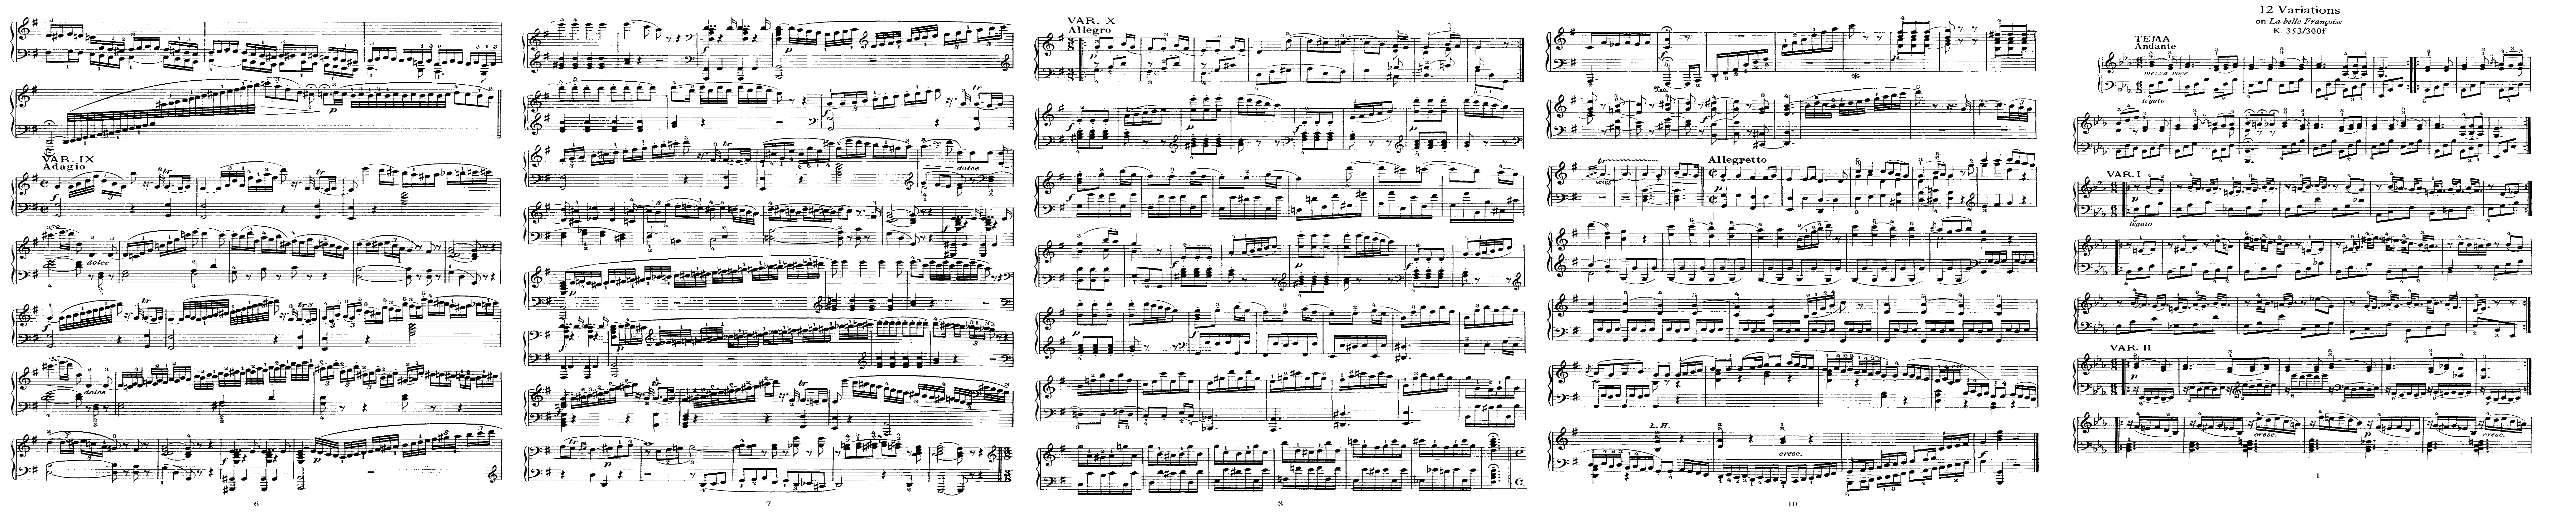

Following 5 images are from the validation set:


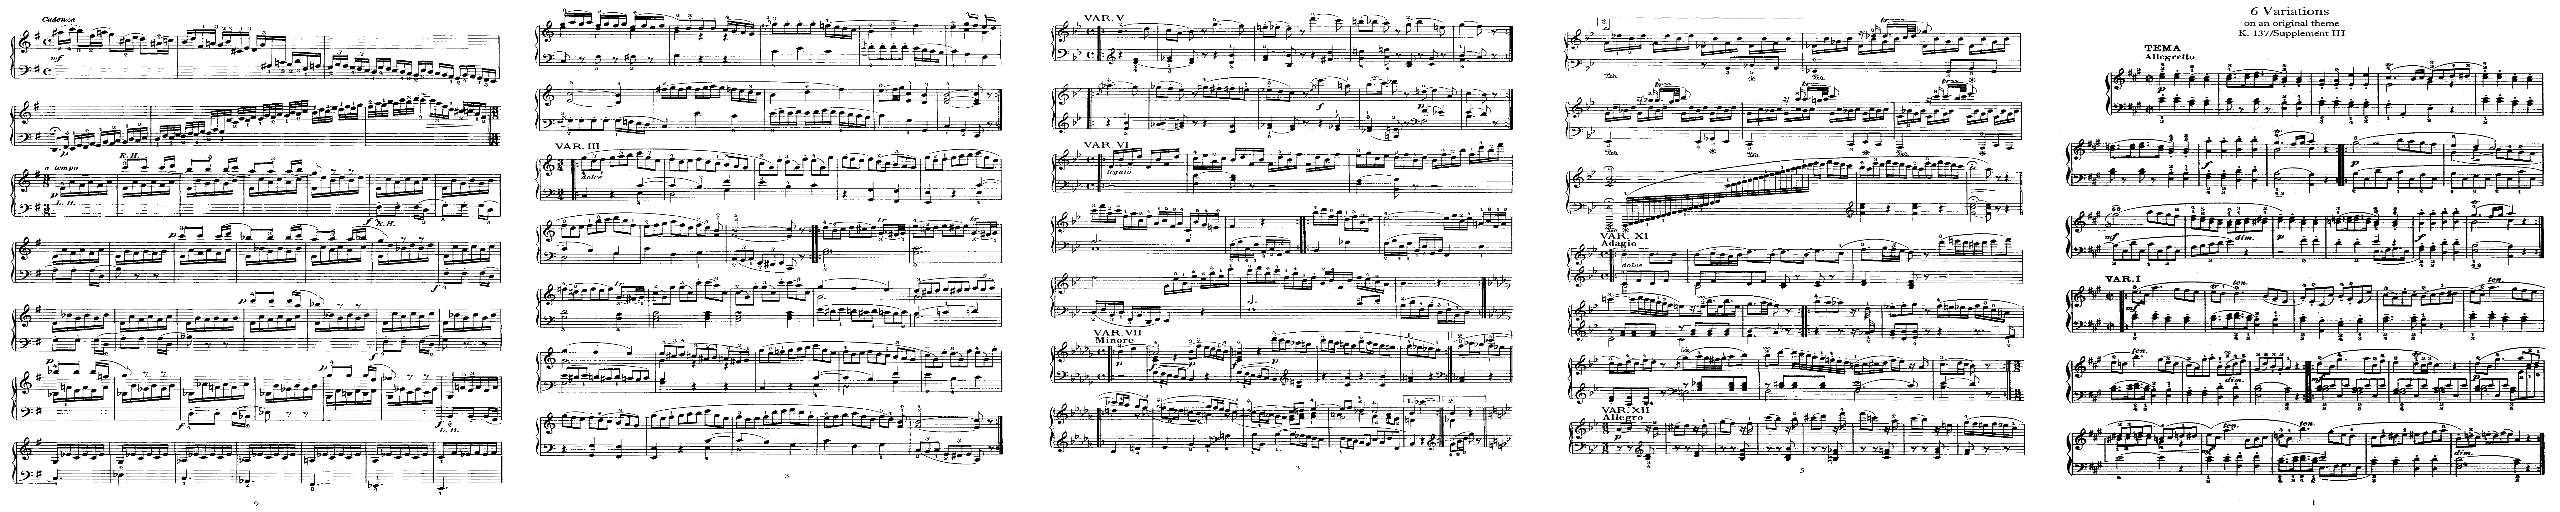

Following 5 images are from the test set:


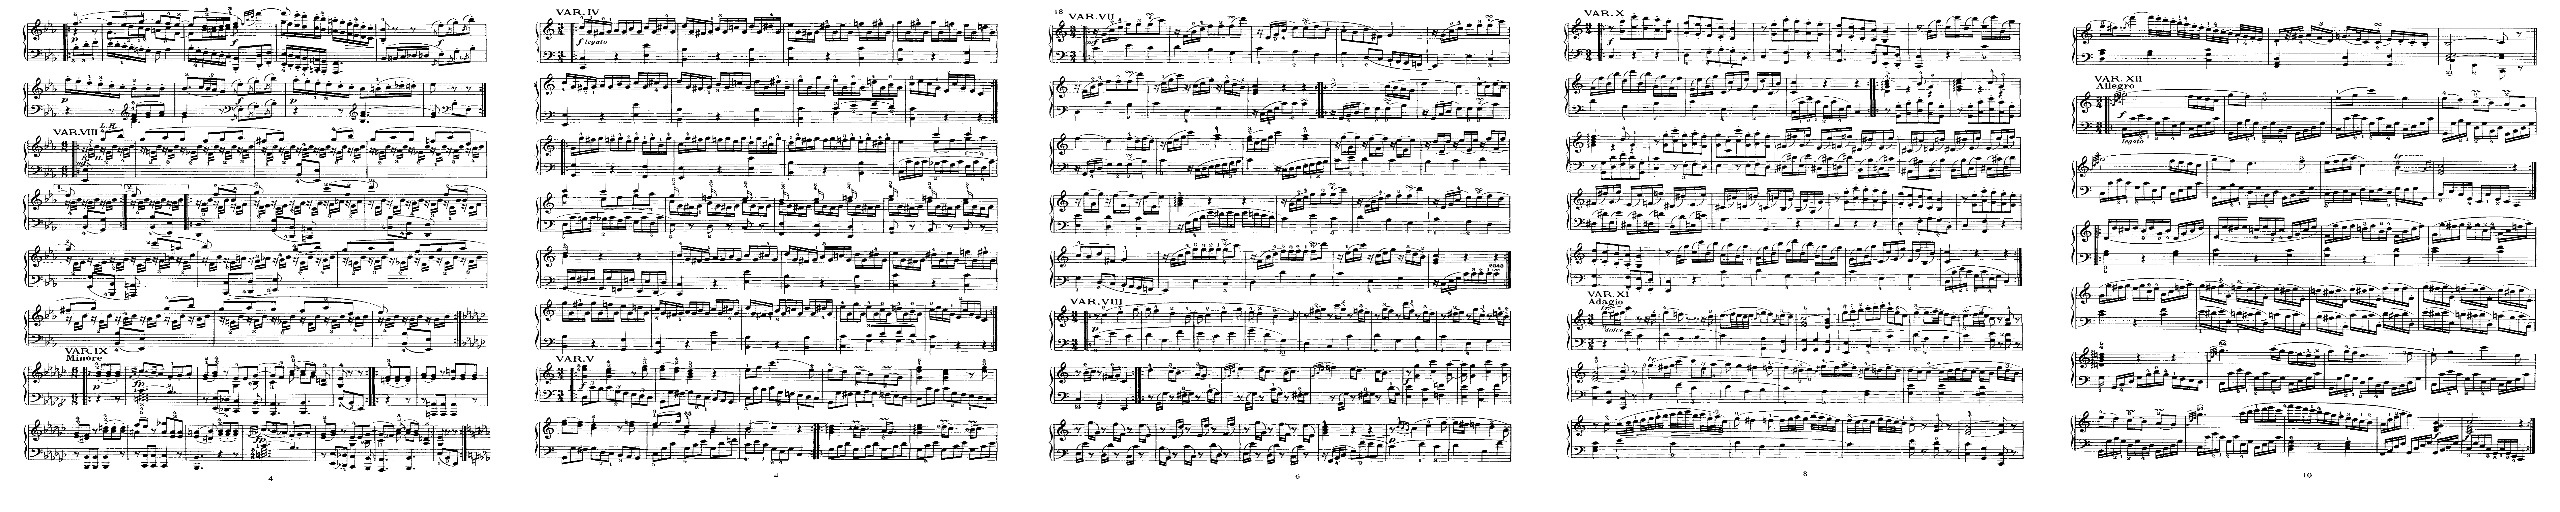

In [ ]:
print("Following 5 images are from the training set:")
# Create a list of the first five images
images_train = [X_train[i] for i in range(5)]

# stack the images and let image display in a horizontal axis
stacked_train_images = np.hstack(images_train)

# Display the stacked images and their label
cv2_imshow(stacked_train_images)

print("=============================================================================================================================================================================")

print("Following 5 images are from the validation set:")
# Create a list of the first five images and display them in a horizotal axis
images_validation = [X_validation[o] for o in range(5)]
stacked_valid_images = np.hstack(images_validation)

# Display the stacked images
cv2_imshow(stacked_valid_images)

print("=============================================================================================================================================================================")

print("Following 5 images are from the test set:")
# Create a list of the first five images and display them in a horizotal axis
images_test = [X_test[j] for j in range(5)]
stacked_test_images = np.hstack(images_test)

# Display the stacked images
cv2_imshow(stacked_test_images)

#### <h3 id="first_CNN"> 3.1.2 Construct the Model </h3>

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

1. In order to maintain detailed features in our model, we input the shape of 512x512 pixal images into our convolutional net (we've tried the larger size, but the computing resource is not sufficient), so we scale down to 512. We normalize the input pixal into 1./255. Afterward, we modify the size of the filter into 128, 256, and 512 to extract as much feature as possible. We also set up the residual block to reduce gradient descent issues. Even though the validation accuracy is 0.6180, we are **not using this model, because we did not measure the balanced weights among the cateogries** - as we observed above, sample sizes various acorss different categories.

In [ ]:
# Define the model architecture, and image pixal size into 512x512 in gray scale
inputs = keras.Input(shape=(512, 512, 1))

# standalized/ normalized the input size
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

# for loop the 
for size in [128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    # Update residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# use the softmax here becuase we are creating a categorial predicution
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint to save the best model in the google drive
checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/drive/Shareddrives/Neural_Network_Project/cnn_model1.h5',
                                             save_best_only=True,
                                             save_weights_only=False,
                                             monitor='val_loss',
                                             mode='min',
                                             verbose=1)

# Train the model by fit
history = model.fit(train_data, epochs=10, validation_data=validation_data, batch_size=30, callbacks=[checkpoint])

# Evaluate the test accuracy
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print("Test accuracy:", test_acc)


Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 4.9222 - accuracy: 0.4189
Epoch 1: val_loss improved from inf to 1.77962, saving model to /content/drive/Shareddrives/Neural_Network_Project/cnn_model1.h5
69/69 [==============================] - 154s 1s/step - loss: 4.9222 - accuracy: 0.4189 - val_loss: 1.7796 - val_accuracy: 0.4317
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 1.2268 - accuracy: 0.5824
Epoch 2: val_loss did not improve from 1.77962
69/69 [==============================] - 41s 589ms/step - loss: 1.2268 - accuracy: 0.5824 - val_loss: 6.2517 - val_accuracy: 0.2205
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 1.0668 - accuracy: 0.6504
Epoch 3: val_loss did not improve from 1.77962
69/69 [==============================] - 41s 590ms/step - loss: 1.0668 - accuracy: 0.6504 - val_loss: 42.7832 - val_accuracy: 0.2174
Epoch 4/10
69/69 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.7206
Epoch 

2. Then we plot the model accuracy and model loss

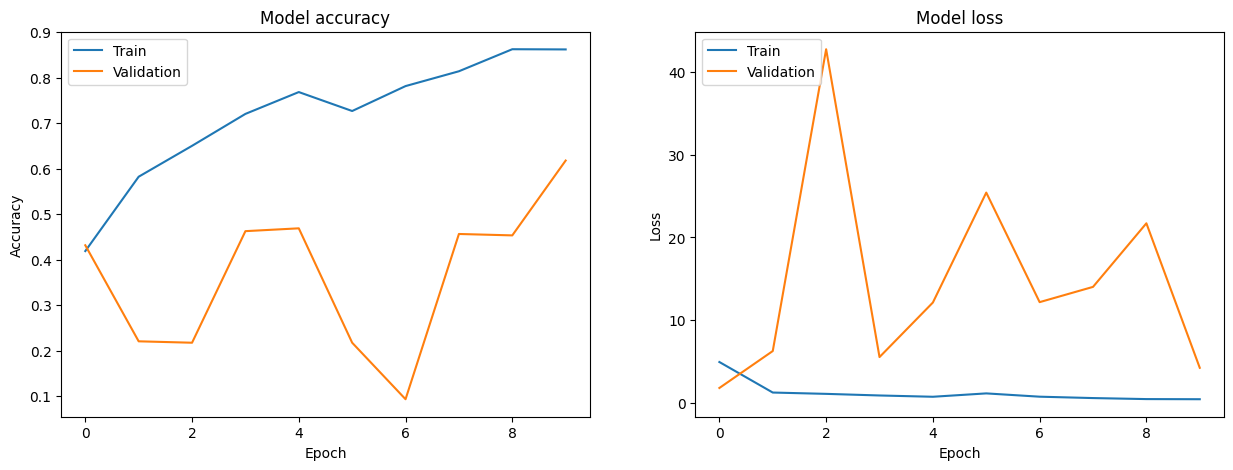

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the accuracy
ax[0].set_title('Model accuracy')
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'])

# Plot the loss
ax[1].set_title('Model loss')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

#### <h3 id="CNN1_summary"> 3.1.3 CNN Model1 Summary </h3>

Total params: 4,784,549 and 25 layers in total

In [ ]:
model_CNN_Model1 = keras.models.load_model("/content/drive/Shareddrives/Neural_Network_Project/cnn_model1.h5")
model_CNN_Model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 508, 508, 32  800         ['rescaling[0][0]']              
                                )                                                                 
                                                                                            

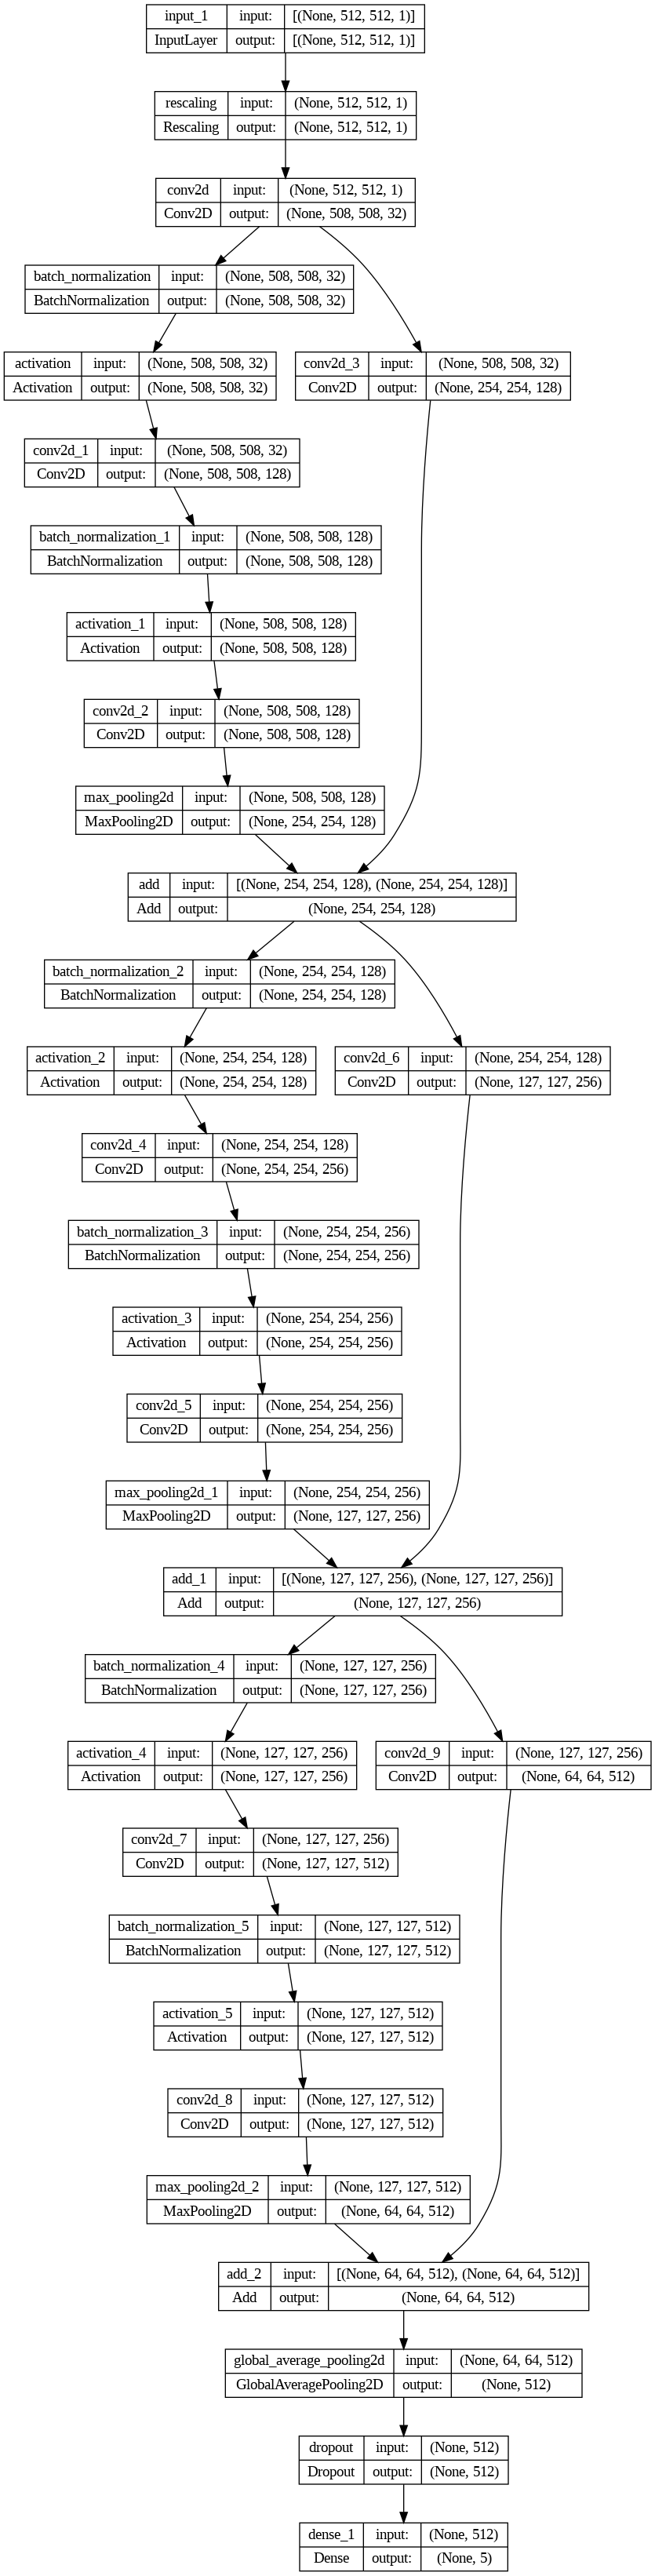

In [ ]:
plot_model(model_CNN_Model1, to_file='model.png', show_shapes=True, show_layer_names=True)

### <h2 id="cnn_model_gs"> 3.2 CNN Model with Grid Search</h2>

Following block of code is using Grid Search to measure the best parameters. When we trying to pass the 512 * 512 image size into the model, following error message shows up, wo downsize to 216*216: 

```
"<ipython-input-14-712efd50153d>:33: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.model = KerasClassifier(build_fn=create_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 23 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.If these failures are not expected, you can try to debug them by setting error_score='raise'.Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1572]"```


So we decide to downsize the image first then try the model. After the model training, we found the accuracy is low so we did not do futher evulation it. Reason behind for low accuracy (0.163949) caused by low resolution image.

#### <h3 id="downsize_img"> 3.2.1 Downsize Images</h3>

In [ ]:
# Load the training data
# X_train is to store the image (matrix) to the list

base_dir = '/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder'

# Define the class names
class_names = ['variations_pieces', 'sonata_pieces', 'rhapsody_pieces', 'prelude_pieces', 'concerto_pieces']

# Define the image size
img_size_216 = (216,216)

X_train_downsized = []
y_train = []

for i, class_name in enumerate(class_names):
    train_dir = os.path.join(base_dir, class_name, 'train')
    for filename in os.listdir(train_dir):
       # Check that the file is a PNG file
       if filename.lower().endswith('.png'):
            img_path = os.path.join(train_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size_216)
            X_train_downsized.append(img)
            y_train.append(i)

# Convert the training data to numpy arrays
X_train_downsized = np.array(X_train_downsized)
y_train = to_categorical(np.array(y_train))

# Create the batch size 32 for each set, reshape the image dimension to fit the CNN model
batch_size = 32
X_train_downsized = np.expand_dims(X_train_downsized, axis=-1)
train_data_downsized = ImageDataGenerator().flow(X_train_downsized, y_train, batch_size=batch_size, shuffle=True)

In [ ]:
X_validation_downsized = []
y_validation = []

for i, class_name in enumerate(class_names):
    val_dir = os.path.join(base_dir, class_name, 'validation')
    for filename in os.listdir(val_dir):
        # Check that the file is a PNG file
        if filename.lower().endswith('.png'):
            img_path = os.path.join(val_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size_512)
            X_validation_downsized.append(img)
            y_validation.append(i)

# Convert the validation data to numpy arrays
X_validation_downsized = np.array(X_validation_downsized)
y_validation = to_categorical(np.array(y_validation))

# Create the batch size 32 for each set, reshape the image dimension to fit the CNN model
batch_size = 32
X_validation_downsized = np.expand_dims(X_validation_downsized, axis=-1)
validation_data_downsized = ImageDataGenerator().flow(X_validation_downsized, y_validation, batch_size=batch_size, shuffle=True)


In [ ]:
X_test_downsized = []
y_test = []

for i, class_name in enumerate(class_names):
    test_dir = os.path.join(base_dir, class_name, 'test')
    for filename in os.listdir(test_dir):
        # Check that the file is a PNG file
       if filename.lower().endswith('.png'):
          img_path = os.path.join(test_dir, filename)
          img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, img_size_512)
          X_test_downsized.append(img)
          y_test.append(i)

# Convert the test data to numpy arrays
X_test_downsized = np.array(X_test_downsized)
y_test = to_categorical(np.array(y_test))

# Create the batch size 32 for each set, reshape the image dimension to fit the CNN model
batch_size = 32
X_test_downsized = np.expand_dims(X_test_downsized, axis=-1)
test_data = ImageDataGenerator().flow(X_test_downsized, y_test, batch_size=batch_size, shuffle=True)

#### <h3 id="gird_search"> 3.2.2 Perform the Gird Search</h3>

In [ ]:
def create_model(dropout_rate=0.05):
    inputs = keras.Input(shape=(216, 216, 1))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(5, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Calculate class weights for each class
class_weights = {}
total_samples = len(y_train)
for i in range(5):
    class_weights[i] = (1 / np.sum(y_train[:,i]) * total_samples) / 5

model = KerasClassifier(build_fn=create_model, verbose=0, dropout_rate=0.05)

param_grid = {
    'dropout_rate': [0.01, 0.05],  # try different dropout rates
    'batch_size': [8],  # reduce batch size, tried 6 times with many computing units still out of RAM so reduce the image size, and finally come out the batch size 8
    'epochs': [20, 30]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, error_score='raise')
grid_result = grid.fit(X_train_downsized, y_train, class_weight=class_weights)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Best: 0.163949 using {'batch_size': 8, 'dropout_rate': 0.01, 'epochs': 30}
0.123641 (0.126570) with: {'batch_size': 8, 'dropout_rate': 0.01, 'epochs': 20}
0.163949 (0.095485) with: {'batch_size': 8, 'dropout_rate': 0.01, 'epochs': 30}
0.163043 (0.090616) with: {'batch_size': 8, 'dropout_rate': 0.05, 'epochs': 20}
0.148551 (0.091119) with: {'batch_size': 8, 'dropout_rate': 0.05, 'epochs': 30}


### <h2 id="CNN_model3"> 3.3 CNN Model 3 (Selected)</h2>

#### <h3 id="CNN_model3_build"> 3.3.1 Construct the Model</h3>


1. Since we already tried many times above, we still want to use the 512*512 image to pass into the CNN model. Comparing with the first CNN model, we add a class weight to reduce the bias of the model. This model perform a slight more stable learning rate, meanwhile has 0.4783 learning rate.

In [ ]:
# Define the model architecture and normalize the image as above
inputs = keras.Input(shape=(512, 512, 1))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

# for loop to get deep into the feature extraction
for size in [128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    # Update residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
# do dropout prevent the overfitting
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint
checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/cnn_model3.h5',
                                             save_best_only=True,
                                             save_weights_only=False,
                                             monitor='val_loss',
                                             mode='min',
                                             verbose=1)

# Calculate class weights
class_weights = {}
total_samples = len(y_train)
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
class_weights = dict(zip(unique, total_samples / counts))

# Train the model
history = model.fit(train_data, epochs=10, validation_data=validation_data,batch_size=30, class_weight=class_weights, callbacks=[checkpoint])

# get the test score accuracy
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print("Test accuracy:", test_acc)


Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 25.8632 - accuracy: 0.3098
Epoch 1: val_loss improved from inf to 23.32662, saving model to /content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/cnn_model3.h5
69/69 [==============================] - 46s 597ms/step - loss: 25.8632 - accuracy: 0.3098 - val_loss: 23.3266 - val_accuracy: 0.0839
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 9.5334 - accuracy: 0.4443
Epoch 2: val_loss improved from 23.32662 to 6.88378, saving model to /content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/cnn_model3.h5
69/69 [==============================] - 42s 606ms/step - loss: 9.5334 - accuracy: 0.4443 - val_loss: 6.8838 - val_accuracy: 0.1615
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 5.8966 - accuracy: 0.5598
Epoch 3: val_loss did not improve from 6.88378
69/69 [==============================] - 41s 590ms/step - loss: 5.8966 - accuracy: 0.5598 - va

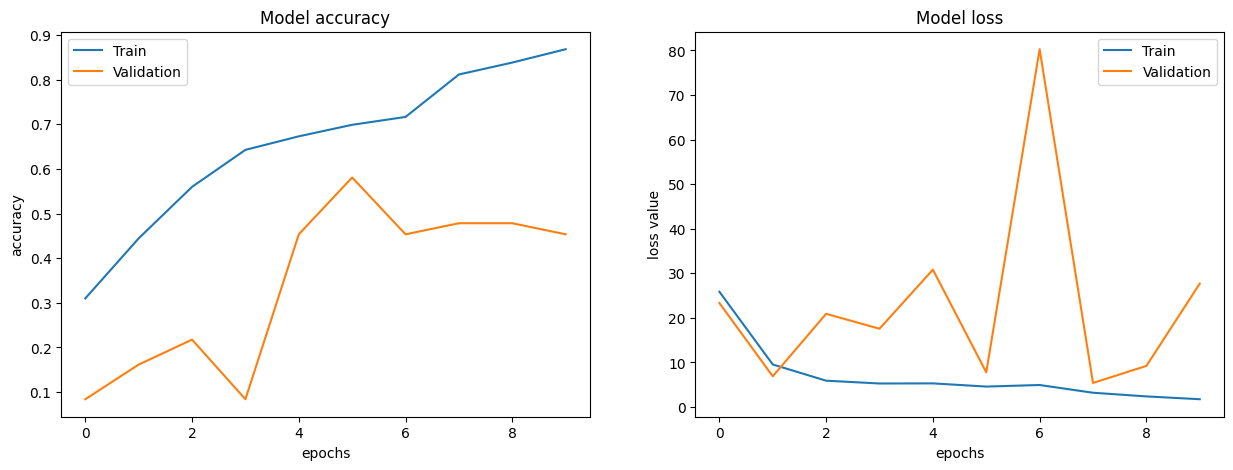

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the accuracy
ax[0].set_title('Model accuracy')
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epochs')
ax[0].legend(['Train', 'Validation'])

# Plot the loss
ax[1].set_title('Model loss')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('loss value')
ax[1].set_xlabel('epochs')
ax[1].legend(['Train', 'Validation'])

plt.show()

#### <h3 id="CNN_model3_summary"> 3.3.2 CNN Model 3 Summary</h3>


This model contain 4,784,549 parameters with 33 layers

In [ ]:
model_CNN_Model_selected = keras.models.load_model("/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/cnn_model3.h5")
model_CNN_Model_selected.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 512, 512, 1)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 508, 508, 32  800         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

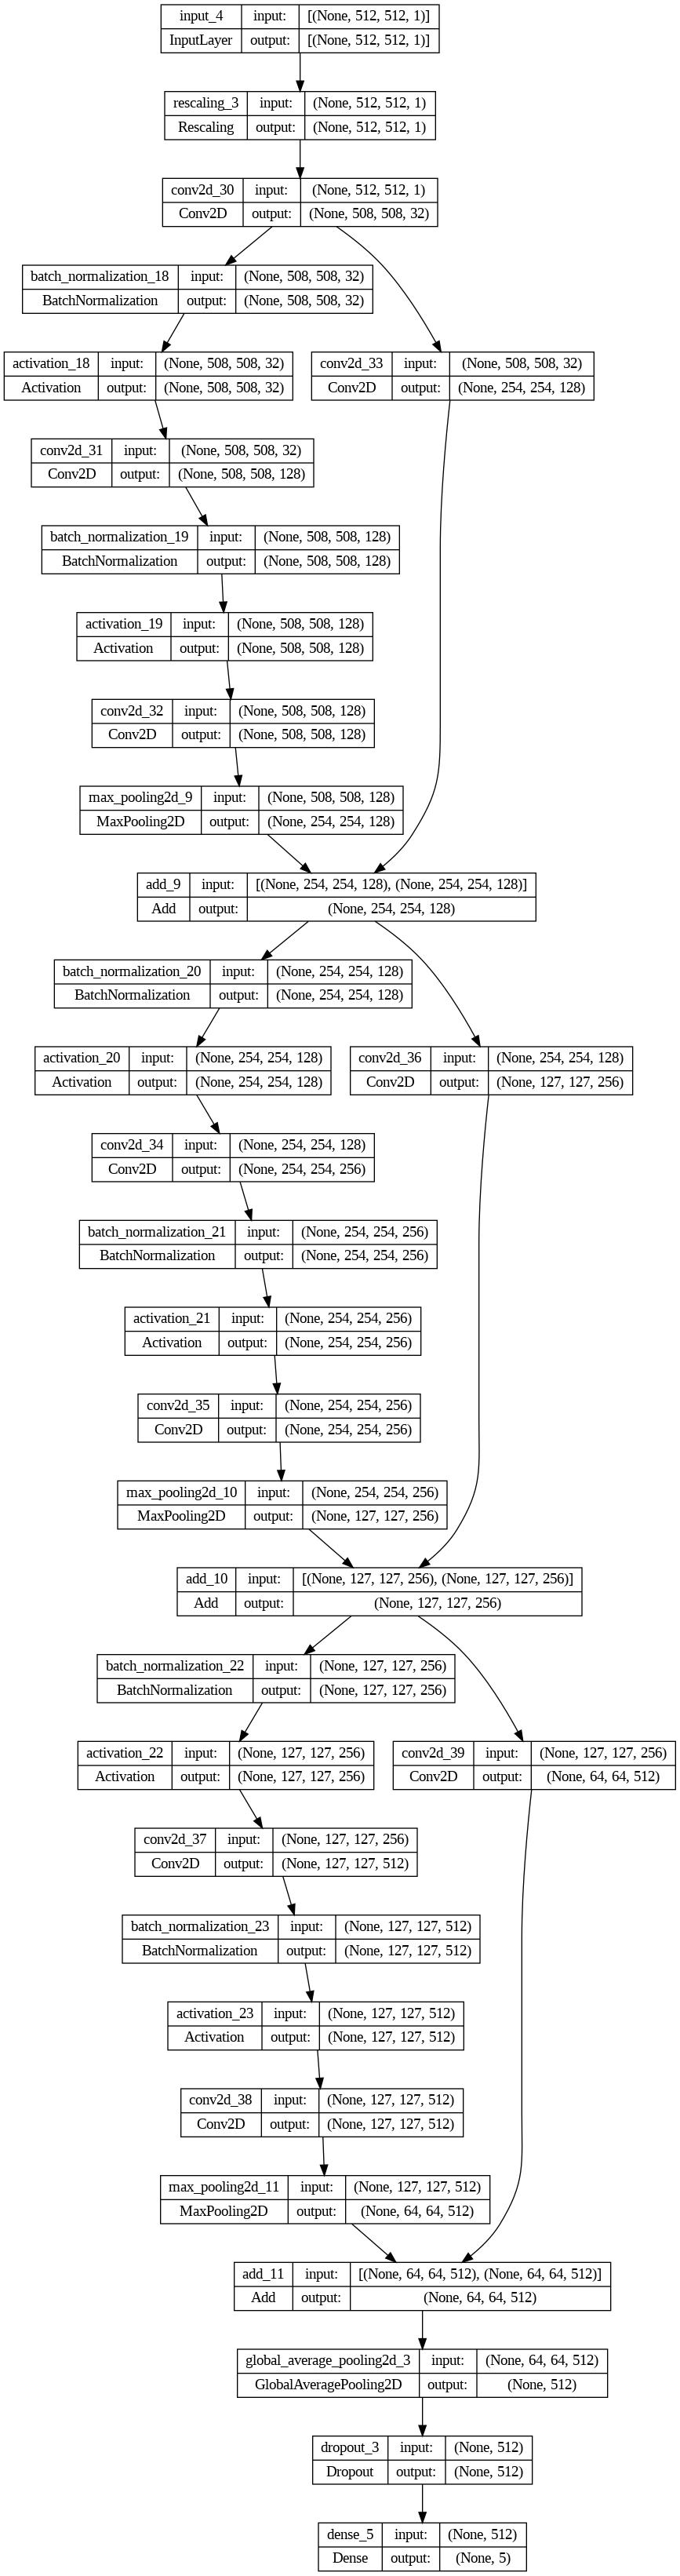

In [ ]:
plot_model(model_CNN_Model_selected, to_file='model1.png', show_shapes=True, show_layer_names=True)

### <h2 id="LSTM"> 3.4 LSTM Model</h2>

#### <h3 id="LSTM"> 3.4.1 Processing before Training</h3>

1. Setup the output parameters, vectorize all the train, validation, and test variables for passing into the RNN model. And add padding and truncating into the dataset make sure the shape is correct.

In [ ]:
output_sequence_length = 5 # Set up the output_sequence_length to 5 because we have 5 output variables

# Set the max_tokens as 2000 words in the dictionary, output sequence_length equal to 5, since we have 5 outputs
text_vectorization = TextVectorization(max_tokens= 2000,  # select 2000, because we tried around with 10000, cost a high RAM to process
                                       output_mode="int",
                                       output_sequence_length=output_sequence_length)

# fit above all the train, validation, test variables into the function
text_vectorization.adapt(train_var + validation_var + test_var)

# transfer them all to the numpy array to ensure all the values can correctly pass into the RNN model
train_var_vectorized = text_vectorization(tf.constant(train_var)).numpy()
validation_var_vectorized = text_vectorization(tf.constant(validation_var)).numpy()
test_var_vectorized = text_vectorization(tf.constant(test_var)).numpy()

In [ ]:
# do the padding and truncating to ensure dataset can pass into the RNN model
train_var_vectorized = pad_sequences(train_var_vectorized, maxlen=2000, padding='post', truncating='post')
validation_var_vectorized = pad_sequences(validation_var_vectorized, maxlen=2000, padding='post', truncating='post')
test_var_vectorized = pad_sequences(test_var_vectorized, maxlen=2000, padding='post', truncating='post')

In [ ]:
print(train_var_vectorized)
print(train_var_vectorized.shape)

[[   0    0    0 ...    0    0    0]
 [  97   98   36 ...    0    0    0]
 [ 152   47   11 ...    0    0    0]
 ...
 [1435   74    1 ...    0    0    0]
 [1965   36   23 ...    0    0    0]
 [ 437    1    2 ...    0    0    0]]
(2208, 2000)


2. Iterate though all text in the training dataset, and split the tokens, then count the length of whole unique values within text/tokens.

In [ ]:
# vacoab size is to count the unique input text then pass into the training model
vocab_size = len(set(word for text in train_var for word in text.split()))

In [ ]:
train_var_vectorized.shape

(2208, 2000)

In [ ]:
validation_labels_encoded.shape

(322, 5)

In [ ]:
print("train_var_vectorized shape:", train_var_vectorized.shape)
print("validation_var_vectorized shape:", validation_var_vectorized.shape)

train_var_vectorized shape: (2208, 2000)
validation_var_vectorized shape: (322, 2000)


#### <h3 id="LSTM_build"> 3.4.2 Construct the Model</h3>

1. Create a LSTM model, since we already padding and truncating the input vectors or lists, the input shape is (2000,). And then add the LSTM function. Both CNN and RNN model use softmax since the final goal is to classify the image. The validation accuracy is also high - 0.5124, even though the learning rate or loss are not stable as in selected CNN model. Due to some muisc piece disclose the infomration of piece type, we wanto to combine the models with CNN and RNN later to balance the model's prediction weights, increase the accuracy, and reduce bias.

In [ ]:
def rnn_model_128():
    model = keras.Sequential()
    model.add(layers.Input(shape=(2000,), dtype="int64"))  # Update the input shape here
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=200)) # use the vector size in vector space with 200
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(256)))
    model.add(keras.layers.Dense(5, activation="softmax"))
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=['accuracy'])
    return model

checkpoint_filepath = '/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/rnn_model_test.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
train_var_vectorized.shape

(2208, 2000)

In [ ]:
# Set the training label into the numpy array, and do the unique label extraction
unique_labels = np.unique(train_labels)

# iterate over a sequence, do indexing for th label
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# then transfer into the list otherwise cannot be muplitated
train_labels_indexed = [label_to_index[label] for label in train_labels]

# define the class weight
class_weights = compute_class_weight("balanced", classes=np.arange(len(unique_labels)), y=train_labels_indexed)

# define a dictionary to store the class weights
class_weight_dict = dict(zip(range(len(unique_labels)), class_weights))


In [ ]:
model = rnn_model_128()
# Train the model with the checkpoint callback

history = model.fit(
    train_var_vectorized,
    train_labels_encoded,
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    validation_data=(validation_var_vectorized, validation_labels_encoded),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 1.6198 - accuracy: 0.1988
Epoch 1: val_accuracy improved from -inf to 0.08385, saving model to /content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/rnn_model_test.h5
69/69 [==============================] - 66s 719ms/step - loss: 1.6198 - accuracy: 0.1988 - val_loss: 1.6208 - val_accuracy: 0.0839
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 1.6127 - accuracy: 0.1993
Epoch 2: val_accuracy improved from 0.08385 to 0.45342, saving model to /content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/rnn_model_test.h5
69/69 [==============================] - 44s 641ms/step - loss: 1.6127 - accuracy: 0.1993 - val_loss: 1.6021 - val_accuracy: 0.4534
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 1.6096 - accuracy: 0.2736
Epoch 3: val_accuracy did not improve from 0.45342
69/69 [==============================] - 43s 620ms/step - loss: 1.6096 - accur

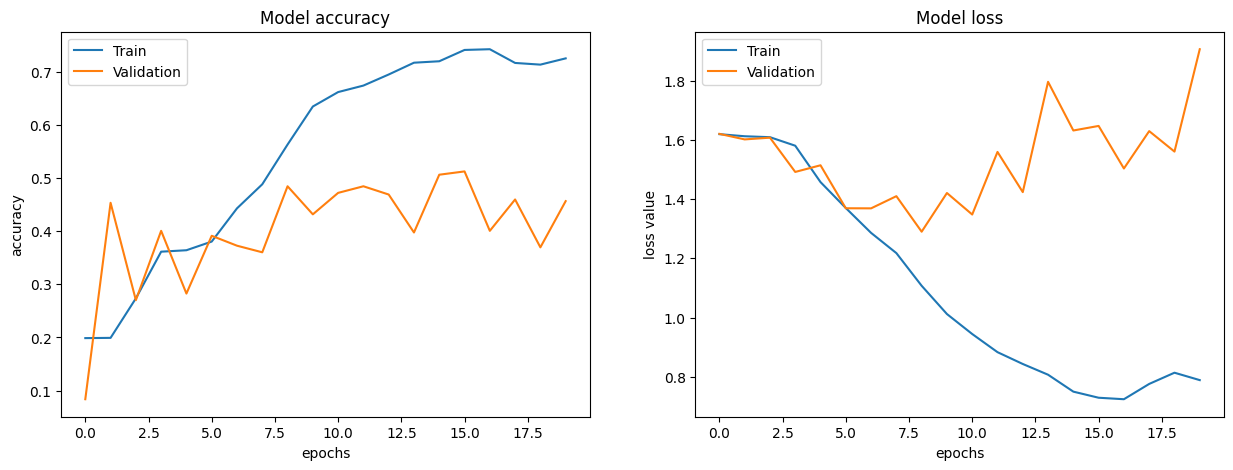

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the accuracy
ax[0].set_title('Model accuracy')
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epochs')
ax[0].legend(['Train', 'Validation'])

# Plot the loss
ax[1].set_title('Model loss')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('loss value')
ax[1].set_xlabel('epochs')
ax[1].legend(['Train', 'Validation'])

plt.show()

#### <h3 id="LSTM_summary"> 3.4.3 LSTM Model Summary</h3>


1. This model contains 10,221,949 parameters in total, 7 layer with bidiretional structure - use the bidirectional structure because it usually lead a better performance in normal text and corpus.

In [ ]:
LSTM_Model_path = '/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/rnn_model_test.h5'
LSTM_Model = keras.models.load_model(LSTM_Model_path)

# Print the model summary
LSTM_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 200)         2983800   
                                                                 
 bidirectional (Bidirectiona  (None, 2000, 512)        935936    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 2000, 512)        1574912   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 2000, 512)        1574912   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 2000, 512)        1574912   
 nal)                                                 

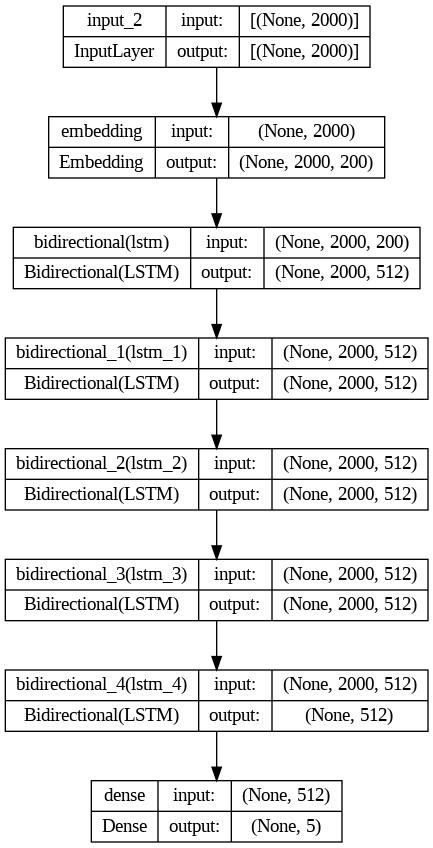

In [ ]:
plot_model(LSTM_Model, to_file='model1.png', show_shapes=True, show_layer_names=True)

### <h2 id="CNN-LSTM"> 3.5 CNN-LSTM Model Combination (Selected)</h2>

#### <h3 id="CNN-LSTM-build"> 3.5.1 Construct the Model</h3>

1. Given the satisfactory prediction performance of both the CNN and LSTM models, we aim to combine them to evaluate their joint performance. The process involves passing image files through the CNN model and feeding the vectorized text into the LSTM model. Afterward, these two models are merged on a one-to-one basis to produce a result. Despite the instability in learning rate and loss, the combined model achieves a validation accuracy of 80.12%.



In [ ]:
# Load the saved models
rnn_final = keras.models.load_model('/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/rnn_model_test.h5')
cnn_final = keras.models.load_model('/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/cnn_model3.h5')

In [ ]:
# Remove the last layer (output layer) of both models
rnn_final_base = Model(inputs=rnn_final.inputs, outputs=rnn_final.layers[-2].output)
cnn_final_base = Model(inputs=cnn_final.inputs, outputs=cnn_final.layers[-2].output)

In [ ]:
def create_stacked_model(cnn_model, rnn_model):
    cnn_input = cnn_model.input
    rnn_input = rnn_model.input
    merged = Concatenate()([cnn_model.output, rnn_model.output])
    x = Dense(64, activation='relu')(merged)
    x = Dropout(0.2)(x)
    outputs = Dense(5, activation='softmax')(x)
    return Model(inputs=[cnn_input, rnn_input], outputs=outputs)

Adding 2 models together

In [ ]:
stacked_model = create_stacked_model(cnn_final_base, rnn_final_base)

In [ ]:
stacked_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint(
    filepath='/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/stacked_model_test.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

Check the input shape

In [ ]:
print(X_test.shape)
print(test_var_vectorized.shape)
print(y_test.shape)
print(validation_var_vectorized.shape)
print("X_train shape:", X_train.shape)
print("train_var_vectorized shape:", train_var_vectorized.shape)

print("RNN model input shape:", rnn_final.layers[0].input_shape)
print("RNN model output shape:", rnn_final.output_shape)
print("CNN model input shape:", cnn_final.layers[0].input_shape)
print("CNN model output shape:", cnn_final.output_shape)



(629, 512, 512, 1)
(629, 2000)
(629, 5)
(322, 2000)
X_train shape: (2208, 512, 512, 1)
train_var_vectorized shape: (2208, 2000)
RNN model input shape: (None, 2000)
RNN model output shape: (None, 5)
CNN model input shape: [(None, 512, 512, 1)]
CNN model output shape: (None, 5)


Repeat the weight balance calculation for both CNN and LSTM models, ensuring the inputs are valid

In [ ]:
#Define the class weights for the dataset
class_weights = {}
total_samples = len(y_train)
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
class_weights = dict(zip(unique, total_samples / counts))


# ensure the input dataset can fit into the model correctly, repeat the abov process
unique_labels = np.unique(train_labels)

# Create a mapping of category name to integer index
label_to_index = {label: index for index, label in enumerate(unique_labels)}
train_labels_indexed = [label_to_index[label] for label in train_labels]

class_weights = compute_class_weight("balanced", classes=np.arange(len(unique_labels)), y=train_labels_indexed)

# Create a dictionary for weights
class_weight_dict = dict(zip(range(len(unique_labels)), class_weights))

In [ ]:
# We've tried the batch_size 64, 32 but the size is bit large (no sufficient computing resources for training the dataset)
history = stacked_model.fit(
    [X_train, train_var_vectorized],
    train_labels_encoded,
    epochs=20,
    batch_size= 16,
    validation_data=([X_validation, validation_var_vectorized], validation_labels_encoded),
    callbacks=[checkpoint],
    class_weight=class_weight_dict
)

test_loss, test_accuracy = stacked_model.evaluate([X_test, test_var_vectorized], test_labels_encoded, verbose=0)
val_loss, val_accuracy = stacked_model.evaluate([X_validation, validation_var_vectorized], validation_labels_encoded, verbose=0)
train_loss, train_accuracy = stacked_model.evaluate([X_train, train_var_vectorized], train_labels_encoded, verbose=0)


Epoch 1/20
138/138 [==============================] - 198s 1s/step - loss: 1.2937 - accuracy: 0.5199 - val_loss: 34.5958 - val_accuracy: 0.1708
Epoch 2/20
138/138 [==============================] - ETA: 0s - loss: 0.8863 - accuracy: 0.6898
Epoch 2: val_loss did not improve from 34.59578
138/138 [==============================] - 120s 867ms/step - loss: 0.8863 - accuracy: 0.6898 - val_loss: 174.8593 - val_accuracy: 0.4534
Epoch 3/20
138/138 [==============================] - ETA: 0s - loss: 0.9237 - accuracy: 0.6943
Epoch 3: val_loss did not improve from 34.59578
138/138 [==============================] - 119s 866ms/step - loss: 0.9237 - accuracy: 0.6943 - val_loss: 73.4828 - val_accuracy: 0.1677
Epoch 4/20
138/138 [==============================] - ETA: 0s - loss: 0.7935 - accuracy: 0.7151
Epoch 4: val_loss did not improve from 34.59578
138/138 [==============================] - 119s 864ms/step - loss: 0.7935 - accuracy: 0.7151 - val_loss: 37.5854 - val_accuracy: 0.4534
Epoch 5/20
138/

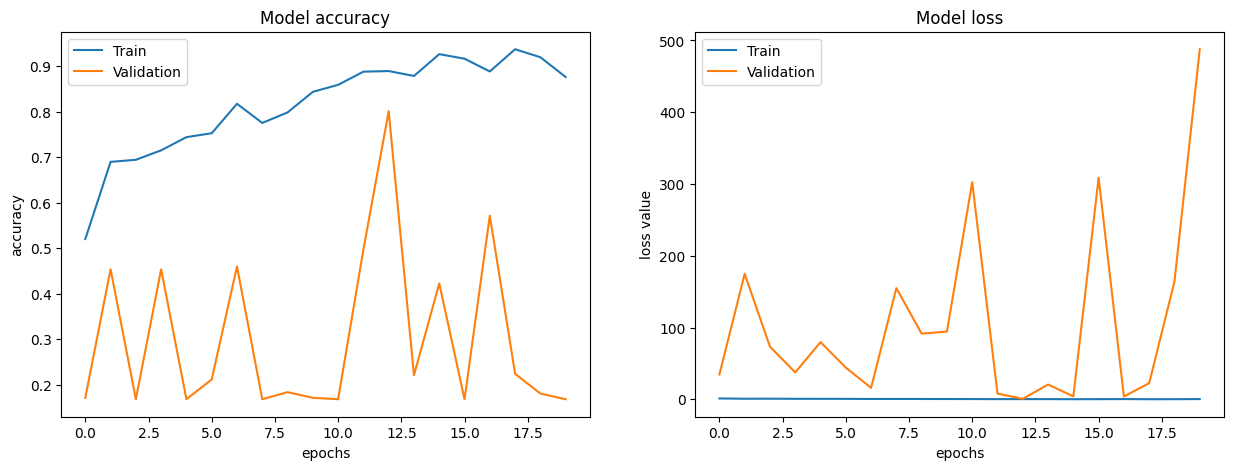

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the accuracy
ax[0].set_title('Model accuracy')
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epochs')
ax[0].legend(['Train', 'Validation'])

# Plot the loss
ax[1].set_title('Model loss')
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('loss value')
ax[1].set_xlabel('epochs')
ax[1].legend(['Train', 'Validation'])

plt.show()

#### <h3 id="CNNLSTM_summary"> 3.5.2 CNN-LSTM Model Summray</h3>

Model contains 15,067,293 total parameters with 43 layers.

In [ ]:
model_path = "/content/drive/Shareddrives/Neural_Network_Project/final_converted_folder/stacked_model_test.h5"
stacked_model = tf.keras.models.load_model(model_path)

# Print the model summary
stacked_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 512, 512, 1)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 508, 508, 32  800         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                            

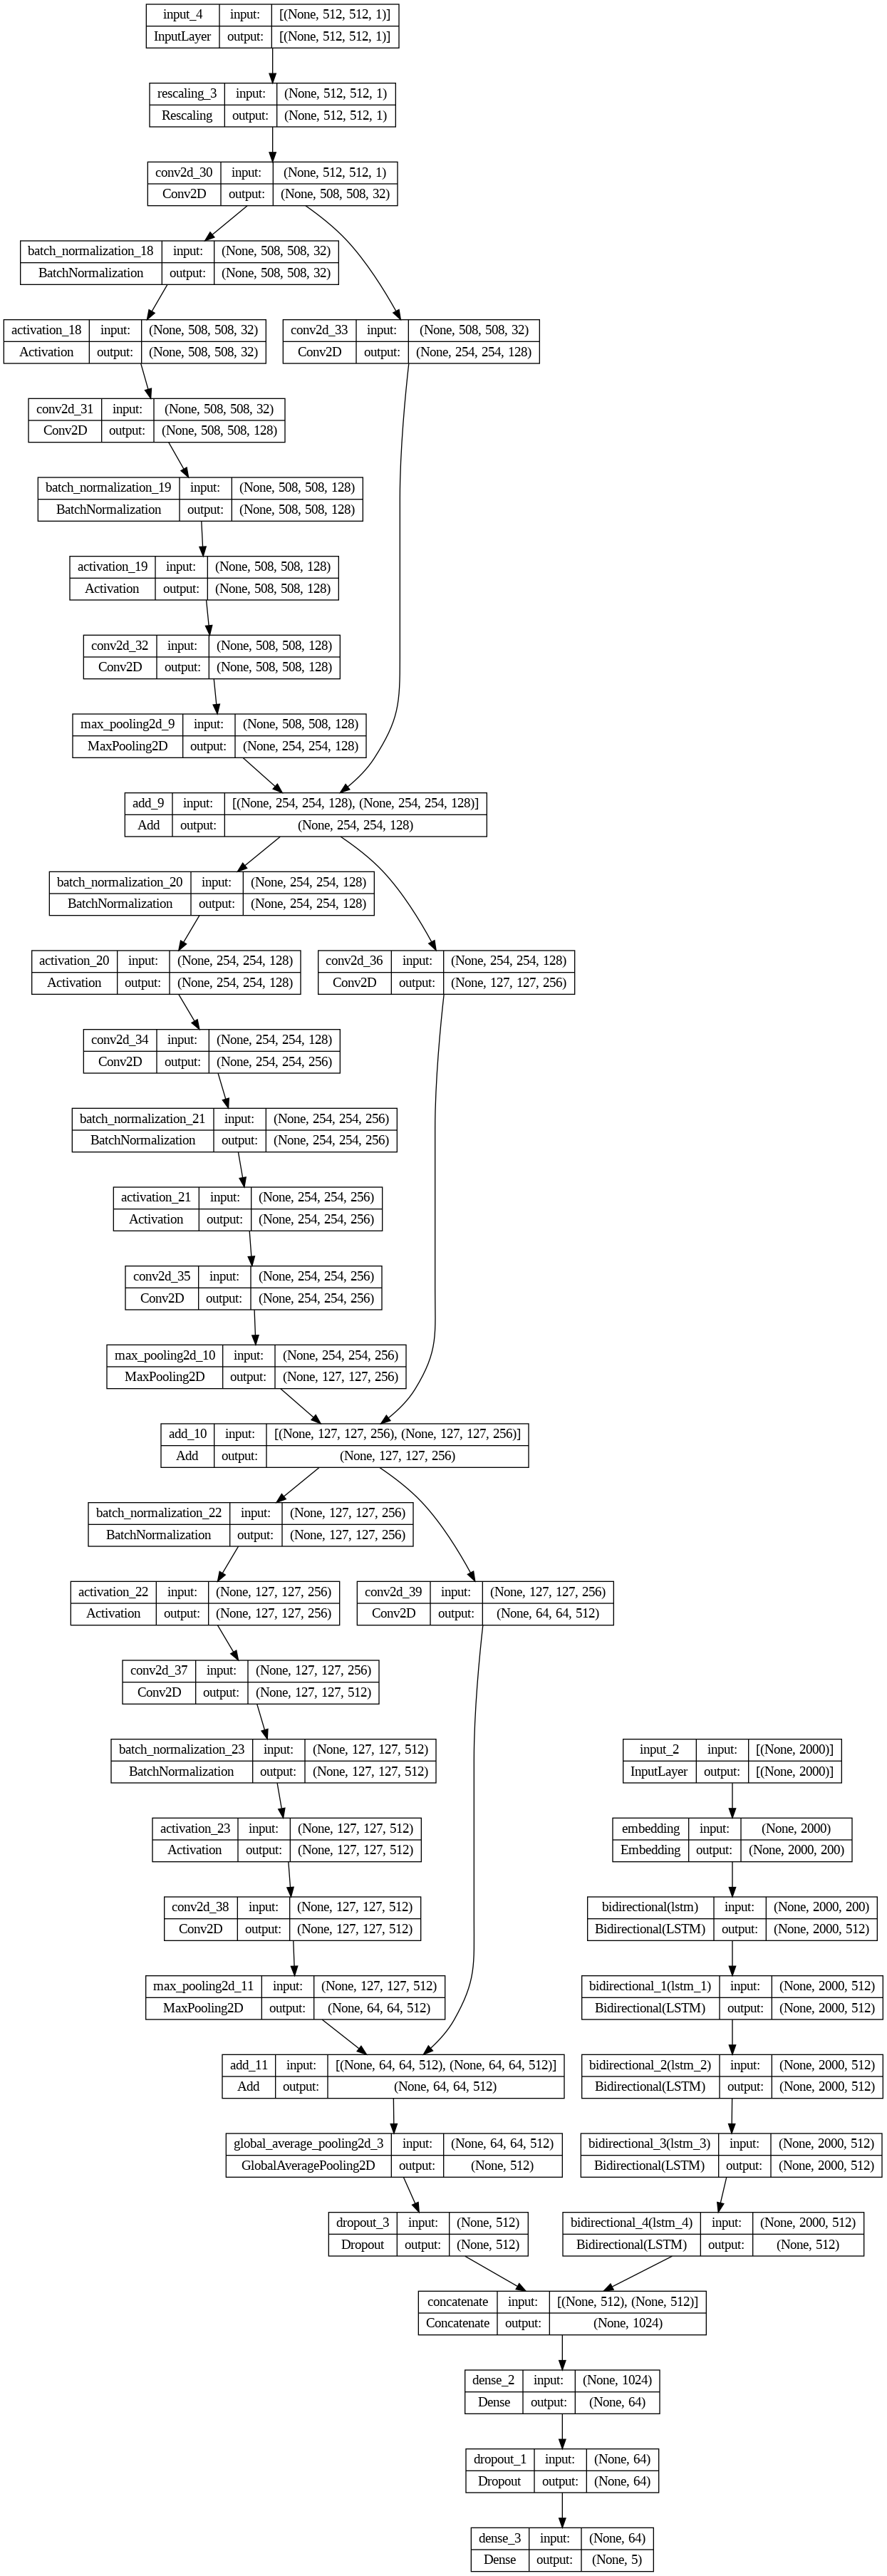

In [ ]:
# Plot the model
plot_model(stacked_model, show_shapes=True, show_layer_names=True, to_file='stacked_model.png')

## <h1 id="conclusion"> 4. Conclusion </h1>

### 4.1 Business Implementation and Competitor Analysis


The idea behind developing a music piece classification model was initially inspired by websites that predominantly sell or provide practice pieces for music players. However, these websites still lack the technology to automatically detect the type of music piece when content creators upload their books. Additionally, content creators may need to provide a label for their creation before uploading it to the platform or publishing it publicly. Our product aims to offer a service to these platforms by enhancing their performance for piece classification and potentially boosting their sales. Our main source of **revenue is selling API services to large platforms**. At the same time, we can utilize their datasets to train our model and achieve higher accuracy. **Our major competitor can be Play Score**, they use the Optical Character Recognition to help player to understand the standard music notation and to paly all kinds of sheet music. Comparing to our competitors, we currently lack the resource to train our model to detect detail notations in each piece; moreover, we lack the investment in hardware to process high resolution images. Since we do have different market share and segementation, sales erosion will not happen in the early stage. 

### 4.2 Model Conclusion

CNN model include the balance weights among all 5 lables and have a slight stable increase in train and validation loss and accuracy, achieve 0.4783 accuracy. Under the condition of 512 * 512 image resolution, the accuracy is slight high. LSTM model has more stable learning rate, training and testing accuracy so have a higher accuracy of 0.5124. However, considering some music book or piece in prelude cateogy will have introdution content in the being of the piece can create some bias. We combine those two model together into CNN-LSTM model. This model can help us to keep the pattern of the music piece; meanwhile to analysis the context of the book. Following is the concepts found on Youtube - https://www.youtube.com/watch?v=7cukyctJg4s.

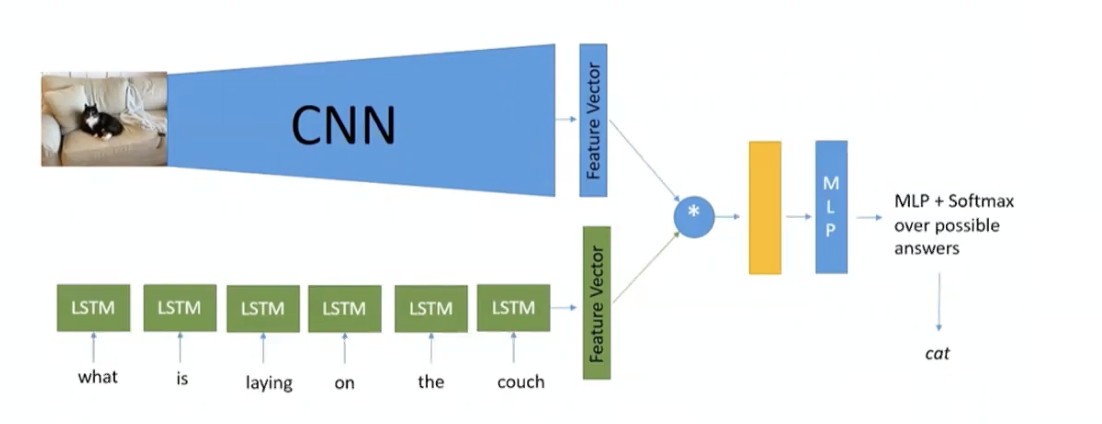

### 4.3 Key Challenges and Limitations

During the model training stage, we occured challenges to train the high resolutional images into our models. Because the image resolution is high, we  unable to run the Grid Search when pass the image size of 512 * 512, (lack of computing resources, even purhcase the colab pro), then we downsize the image or reduce the batch size. Downsizing the sample lead the drop in the accuracy. Secondly, we lack the knowledge in music. If we have enough knowledge or expertie helps us on explain what each notation represents, we can do more feature engineering for all pieces for the RNN model and increase both categories size and sample size.

### 4.4 Relevant Project on Internet 

- Use audio data to do the music classification: https://github.com/brucewlee/Music-Genre-Classification
- Detailized the feature extraction to improve the model accuracy: https://github.com/Audiveris/audiveris
- Build model with both audio and image datasets: https://github.com/BreezeWhite/oemer